In [39]:
import matplotlib.pyplot as plt
from matplotlib import colors
import mplhep as hep
import scipy
hep.style.use(hep.style.CMS)

import numpy as np
import awkward as ak
import hist as hist2
from coffea import processor
from coffea.nanoevents.methods import candidate, vector
from coffea.analysis_tools import Weights, PackedSelection
from hist.intervals import clopper_pearson_interval

import warnings
warnings.filterwarnings("ignore", message="Found duplicate branch")

def getParticles(genparticles,lowid=22,highid=25,flags=['fromHardProcess', 'isLastCopy']):
    """
    returns the particle objects that satisfy a low id, 
    high id condition and have certain flags
    """
    absid = abs(genparticles.pdgId)
    return genparticles[
        ((absid >= lowid) & (absid <= highid))
        & genparticles.hasFlags(flags)
    ]

def match_higgs(genparticles,candidatefj):
    higgs = getParticles(genparticles,25)
    is_hWW = ak.all(abs(higgs.children.pdgId)==24,axis=2)
        
    return higgs[is_hWW]


class lepIsolationEffProcessor(processor.ProcessorABC):
    def __init__(self, year="2017", jet_arbitration='met'):
        self._year = year
        self._jet_arbitration = jet_arbitration
        
        # output
        self.make_output = lambda: {
            'sumw': 0.,
            'signal_kin': hist2.Hist(
                hist2.axis.StrCategory([], name="region", growth=True),
                hist2.axis.Regular(50, 10, 1000, name='genHpt', label=r'genH $p_T$ [GeV]'),
                hist2.storage.Weight(),
            ),
        }
        
    def process(self, events):
        dataset = events.metadata['dataset']
        selection = PackedSelection()
        weights = Weights(len(events), storeIndividual=True)
        weights.add('genweight', events.genWeight)
        
        output = self.make_output()
        output['sumw'] = ak.sum(events.genWeight)
            
        # leptons
        goodmuon = (
            (events.Muon.pt > 25)
            & (abs(events.Muon.eta) < 2.4)
            & events.Muon.mediumId
        )
        nmuons = ak.sum(goodmuon, axis=1)
        lowptmuon = (
            (events.Muon.pt > 10)
            & (abs(events.Muon.eta) < 2.4)
            & events.Muon.looseId
        )
        nlowptmuons = ak.sum(lowptmuon, axis=1)
            
        goodelectron = (
            (events.Electron.pt > 25)
            & (abs(events.Electron.eta) < 2.5)
            & (events.Electron.mvaFall17V2noIso_WP80)
        )
        nelectrons = ak.sum(goodelectron, axis=1)
        lowptelectron = (
            (events.Electron.pt > 10)
            & (abs(events.Electron.eta) < 2.5)
            & (events.Electron.cutBased >= events.Electron.LOOSE)
        )
        nlowptelectrons = ak.sum(lowptelectron, axis=1)
        
        goodtau = (
            (events.Tau.pt > 20)
            & (abs(events.Tau.eta) < 2.3)
            & (events.Tau.idAntiEle >= 8)
            & (events.Tau.idAntiMu >= 1)
        )
        ntaus = ak.sum(goodtau, axis=1)

        # concatenate leptons and select leading one
        goodleptons = ak.concatenate([events.Muon[goodmuon], events.Electron[goodelectron]], axis=1)
        candidatelep = ak.firsts(goodleptons[ak.argsort(goodleptons.pt)])
        candidatelep_p4 = ak.zip(
            {
                "pt": candidatelep.pt,
                "eta": candidatelep.eta,
                "phi": candidatelep.phi,
                "mass": candidatelep.mass,
                "charge": candidatelep.charge,
            },
            with_name="PtEtaPhiMCandidate",
            behavior=candidate.behavior,
        )
        
        # lepton isolation
        lep_miniIso = candidatelep.miniPFRelIso_all
        lep_relIso = candidatelep.pfRelIso03_all
        
        # select events for some iso wp
        selection.add("miniIsoI", lep_miniIso < 0.1)
        selection.add("miniIsoII", lep_miniIso < 0.2)
        selection.add("miniIsoIII", lep_miniIso < 0.3)
        selection.add("relIsoI", lep_relIso < 0.1)
        selection.add("relIsoII", lep_relIso < 0.2)
        selection.add("relIsoIII", lep_relIso < 0.3)
        
        # missing transverse energy
        met = events.MET
        
        # jets
        fatjets = events.FatJet
        candidatefj = fatjets[
            (fatjets.pt > 200)
        ]

        dphi_met_fj = abs(candidatefj.delta_phi(met))
        dr_lep_fj = candidatefj.delta_r(candidatelep_p4)
    
        if self._jet_arbitration == 'pt':
            candidatefj = ak.firsts(candidatefj)
        elif self._jet_arbitration == 'met':
            candidatefj = ak.firsts(candidatefj[ak.argmin(dphi_met_fj,axis=1,keepdims=True)])
        elif self._jet_arbitration == 'lep':
            candidatefj = ak.firsts(candidatefj[ak.argmin(dr_lep_fj,axis=1,keepdims=True)])
        else:
            raise RuntimeError("Unknown candidate jet arbitration")
    
        # select only leptons inside the jet
        dr_lep_jet_cut = candidatefj.delta_r(candidatelep_p4) < 0.8
        dr_lep_jet_cut = ak.fill_none(dr_lep_jet_cut, False)
        selection.add("dr_lep_jet", dr_lep_jet_cut)
        
        genhiggs = match_higgs(events.GenPart,candidatefj)

        
        # select events with only electrons or muons
        selection.add('onemuon', (nmuons == 1) & (nlowptmuons <= 1) & (nelectrons == 0) & (nlowptelectrons == 0) & (ntaus == 0))
        selection.add('oneelectron', (nelectrons == 1) & (nlowptelectrons <= 1) & (nmuons == 0) & (nlowptmuons == 0) & (ntaus == 0))
      
        # no cuts
        selection.add("all", np.ones(len(events), dtype='bool'))
        
        regions = {
            # without dr_lep_jet
            "hadel": ["oneelectron"],
            "hadmu": ["onemuon"],
            "hadel_miniI": ["oneelectron","miniIsoI"],
            "hadel_miniII": ["oneelectron","miniIsoII"],
            "hadel_miniIII": ["oneelectron","miniIsoIII"],
            "hadmu_miniI": ["onemuon","miniIsoI"],
            "hadmu_miniII": ["onemuon","miniIsoII"],
            "hadmu_miniIII": ["onemuon","miniIsoIII"],
            "hadel_relI": ["oneelectron","relIsoI"],
            "hadel_relII": ["oneelectron","relIsoII"],
            "hadel_relIII": ["oneelectron","relIsoIII"],
            "hadmu_relI": ["onemuon","relIsoI"],
            "hadmu_relII": ["onemuon","relIsoII"],
            "hadmu_relIII": ["onemuon","relIsoIII"],
            
            # with dr_lep_jet
            "hadel_dr": ["oneelectron", "dr_lep_jet"],
            "hadmu_dr": ["onemuon", "dr_lep_jet"],
            "hadel_miniI_dr": ["oneelectron","dr_lep_jet","miniIsoI"],
            "hadel_miniII_dr": ["oneelectron","dr_lep_jet","miniIsoII"],
            "hadel_miniIII_dr": ["oneelectron","dr_lep_jet","miniIsoIII"],
            "hadmu_miniI_dr": ["onemuon","dr_lep_jet","miniIsoI"],
            "hadmu_miniII_dr": ["onemuon","dr_lep_jet","miniIsoII"],
            "hadmu_miniIII_dr": ["onemuon","dr_lep_jet","miniIsoIII"],
            "hadel_relI_dr": ["oneelectron","dr_lep_jet","relIsoI"],
            "hadel_relII_dr": ["oneelectron","dr_lep_jet","relIsoII"],
            "hadel_relIII_dr": ["oneelectron","dr_lep_jet","relIsoIII"],
            "hadmu_relI_dr": ["onemuon","dr_lep_jet","relIsoI"],
            "hadmu_relII_dr": ["onemuon","dr_lep_jet","relIsoII"],
            "hadmu_relIII_dr": ["onemuon","dr_lep_jet","relIsoIII"],
        }
        
        # function to normalize arrays after a cut or selection
        def normalize(val, cut=None):
            if cut is None:
                ar = ak.to_numpy(ak.fill_none(val, np.nan))
                return ar
            else:
                ar = ak.to_numpy(ak.fill_none(val[cut], np.nan))
                return ar
    
        # lepton kin
        def fill(region):
            selections = regions[region]
            cut = selection.all(*selections)
            
            output['signal_kin'].fill(
                region = region,
                genHpt = normalize(ak.firsts(genhiggs.pt), cut),
                weight = weights.weight()[cut],
            )
            
        for region in regions:
            fill(region)
        
        return {dataset: output}
            
    def postprocess(self, accumulator):
        return accumulator

In [2]:
from dask.distributed import Client

client = Client("tls://daniel-2eocampo-2ehenao-40cern-2ech.dask.coffea.casa:8786")
client

<Client: 'tls://192.168.42.157:8786' processes=2 threads=4, memory=12.72 GiB>

In [41]:
fileset = {
    'HWW': ["root://xcache/" + file for file in np.loadtxt("data/hwwdata.txt", dtype=str)]
}

hwwout = processor.run_uproot_job(
    fileset,
    treename="Events",
    processor_instance=lepIsolationEffProcessor(),
    executor=processor.dask_executor,
    executor_args={
        "schema": processor.NanoAODSchema,
        "client": client,
    },
        maxchunks=30,
)
h = hwwout["HWW"]["signal_kin"]

In [42]:
def error(num, den):
    return abs(clopper_pearson_interval(num.values(), den.values()) - num.values()/den.values())

def get_axis(den):
    return [den.axes.value(i)[0] for i in range(len(den.values()))]

/tmp/ipykernel_934/2640079242.py:2: RuntimeWarning: invalid value encountered in true_divide
  return abs(clopper_pearson_interval(num.values(), den.values()) - num.values()/den.values())
/tmp/ipykernel_934/1892770079.py:20: RuntimeWarning: invalid value encountered in true_divide
  num1.values()/den.values(),
/tmp/ipykernel_934/1892770079.py:28: RuntimeWarning: invalid value encountered in true_divide
  num2.values()/den.values(),
/tmp/ipykernel_934/1892770079.py:36: RuntimeWarning: invalid value encountered in true_divide
  num3.values()/den.values(),


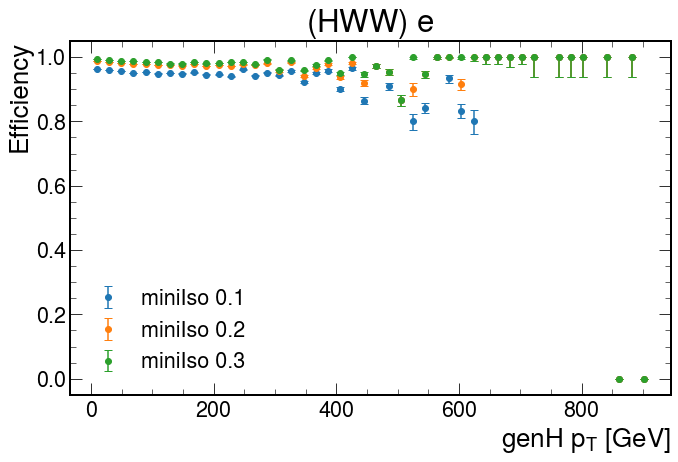

In [52]:
# electron isolation

den = h[{"region":"hadel"}]
num1 = h[{"region":"hadel_miniI"}]
num2 = h[{"region":"hadel_miniII"}]
num3 = h[{"region":"hadel_miniIII"}]

genhpt = get_axis(den)
errI = error(num1, den)
errII = error(num2, den)
errIII = error(num3, den)

fig, ax = plt.subplots(
    figsize=(10,7),
    tight_layout=True,
)

ax.errorbar(
    genhpt,
    num1.values()/den.values(),
    fmt="o",
    yerr=errI,
    capsize=4,
    label="miniIso 0.1"
)
ax.errorbar(
    genhpt,
    num2.values()/den.values(),
    fmt="o",
    yerr=errII,
    capsize=4,
    label="miniIso 0.2"
)
ax.errorbar(
    genhpt,
    num3.values()/den.values(),
    fmt="o",
    yerr=errIII,
    capsize=4,
    label="miniIso 0.3"
)
ax.set(
    title="(HWW) $e$",
    xlabel="genH $p_T$ [GeV]",
    ylabel="Efficiency"
)
ax.legend()
plt.gcf().savefig("hww_eminiIsoeff.png")

/tmp/ipykernel_934/2640079242.py:2: RuntimeWarning: invalid value encountered in true_divide
  return abs(clopper_pearson_interval(num.values(), den.values()) - num.values()/den.values())
/tmp/ipykernel_934/1721878720.py:18: RuntimeWarning: invalid value encountered in true_divide
  num1.values()/den.values(),
/tmp/ipykernel_934/1721878720.py:26: RuntimeWarning: invalid value encountered in true_divide
  num2.values()/den.values(),
/tmp/ipykernel_934/1721878720.py:34: RuntimeWarning: invalid value encountered in true_divide
  num3.values()/den.values(),


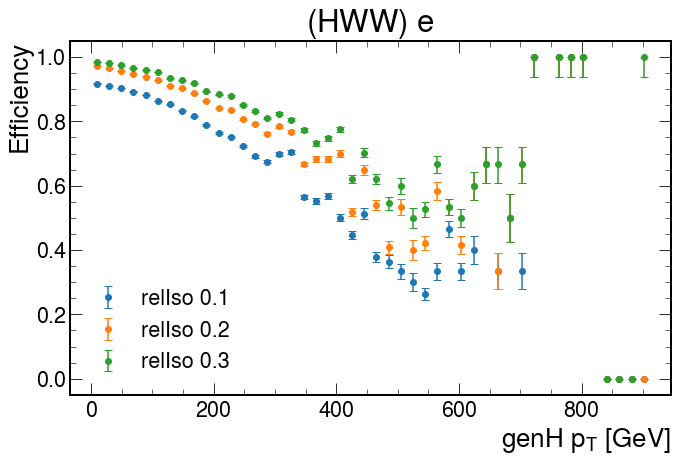

In [53]:
den = h[{"region":"hadel"}]
num1 = h[{"region":"hadel_relI"}]
num2 = h[{"region":"hadel_relII"}]
num3 = h[{"region":"hadel_relIII"}]

genhpt = get_axis(den)
errI = error(num1, den)
errII = error(num2, den)
errIII = error(num3, den)

fig, ax = plt.subplots(
    figsize=(10,7),
    tight_layout=True,
)

ax.errorbar(
    genhpt,
    num1.values()/den.values(),
    fmt="o",
    yerr=errI,
    capsize=4,
    label="relIso 0.1"
)
ax.errorbar(
    genhpt,
    num2.values()/den.values(),
    fmt="o",
    yerr=errII,
    capsize=4,
    label="relIso 0.2"
)
ax.errorbar(
    genhpt,
    num3.values()/den.values(),
    fmt="o",
    yerr=errIII,
    capsize=4,
    label="relIso 0.3"
)
ax.set(
    title="(HWW) $e$",
    xlabel="genH $p_T$ [GeV]",
    ylabel="Efficiency"
)
ax.legend()
plt.gcf().savefig("hww_erelIsoeff.png")

/tmp/ipykernel_934/2640079242.py:2: RuntimeWarning: invalid value encountered in true_divide
  return abs(clopper_pearson_interval(num.values(), den.values()) - num.values()/den.values())
/tmp/ipykernel_934/982563309.py:20: RuntimeWarning: invalid value encountered in true_divide
  num1.values()/den.values(),
/tmp/ipykernel_934/982563309.py:28: RuntimeWarning: invalid value encountered in true_divide
  num2.values()/den.values(),
/tmp/ipykernel_934/982563309.py:36: RuntimeWarning: invalid value encountered in true_divide
  num3.values()/den.values(),


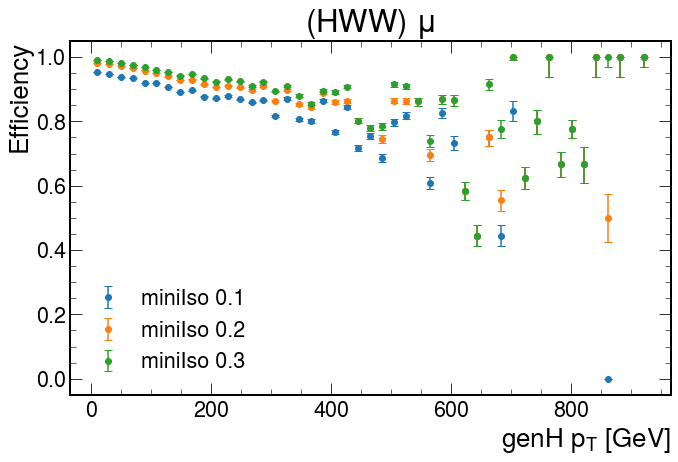

In [54]:
# electron isolation

den = h[{"region":"hadmu"}]
num1 = h[{"region":"hadmu_miniI"}]
num2 = h[{"region":"hadmu_miniII"}]
num3 = h[{"region":"hadmu_miniIII"}]

genhpt = get_axis(den)
errI = error(num1, den)
errII = error(num2, den)
errIII = error(num3, den)

fig, ax = plt.subplots(
    figsize=(10,7),
    tight_layout=True,
)

ax.errorbar(
    genhpt,
    num1.values()/den.values(),
    fmt="o",
    yerr=errI,
    capsize=4,
    label="miniIso 0.1"
)
ax.errorbar(
    genhpt,
    num2.values()/den.values(),
    fmt="o",
    yerr=errII,
    capsize=4,
    label="miniIso 0.2"
)
ax.errorbar(
    genhpt,
    num3.values()/den.values(),
    fmt="o",
    yerr=errIII,
    capsize=4,
    label="miniIso 0.3"
)
ax.set(
    title="(HWW) $\mu$",
    xlabel="genH $p_T$ [GeV]",
    ylabel="Efficiency"
)
ax.legend()
plt.gcf().savefig("hww_muminiIsoeff.png")

/tmp/ipykernel_934/2640079242.py:2: RuntimeWarning: invalid value encountered in true_divide
  return abs(clopper_pearson_interval(num.values(), den.values()) - num.values()/den.values())
/tmp/ipykernel_934/1580277486.py:18: RuntimeWarning: invalid value encountered in true_divide
  num1.values()/den.values(),
/tmp/ipykernel_934/1580277486.py:26: RuntimeWarning: invalid value encountered in true_divide
  num2.values()/den.values(),
/tmp/ipykernel_934/1580277486.py:34: RuntimeWarning: invalid value encountered in true_divide
  num3.values()/den.values(),


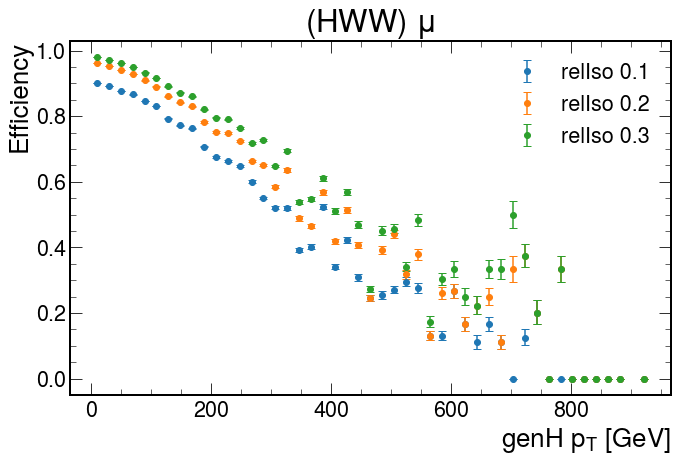

In [55]:
den = h[{"region":"hadmu"}]
num1 = h[{"region":"hadmu_relI"}]
num2 = h[{"region":"hadmu_relII"}]
num3 = h[{"region":"hadmu_relIII"}]

genhpt = get_axis(den)
errI = error(num1, den)
errII = error(num2, den)
errIII = error(num3, den)

fig, ax = plt.subplots(
    figsize=(10,7),
    tight_layout=True,
)

ax.errorbar(
    genhpt,
    num1.values()/den.values(),
    fmt="o",
    yerr=errI,
    capsize=4,
    label="relIso 0.1"
)
ax.errorbar(
    genhpt,
    num2.values()/den.values(),
    fmt="o",
    yerr=errII,
    capsize=4,
    label="relIso 0.2"
)
ax.errorbar(
    genhpt,
    num3.values()/den.values(),
    fmt="o",
    yerr=errIII,
    capsize=4,
    label="relIso 0.3"
)
ax.set(
    title="(HWW) $\mu$",
    xlabel="genH $p_T$ [GeV]",
    ylabel="Efficiency"
)
ax.legend()
plt.gcf().savefig("hww_murelIsoeff.png")

/tmp/ipykernel_934/2640079242.py:2: RuntimeWarning: invalid value encountered in true_divide
  return abs(clopper_pearson_interval(num.values(), den.values()) - num.values()/den.values())
/tmp/ipykernel_934/832468503.py:20: RuntimeWarning: invalid value encountered in true_divide
  num1.values()/den.values(),
/tmp/ipykernel_934/832468503.py:28: RuntimeWarning: invalid value encountered in true_divide
  num2.values()/den.values(),
/tmp/ipykernel_934/832468503.py:36: RuntimeWarning: invalid value encountered in true_divide
  num3.values()/den.values(),


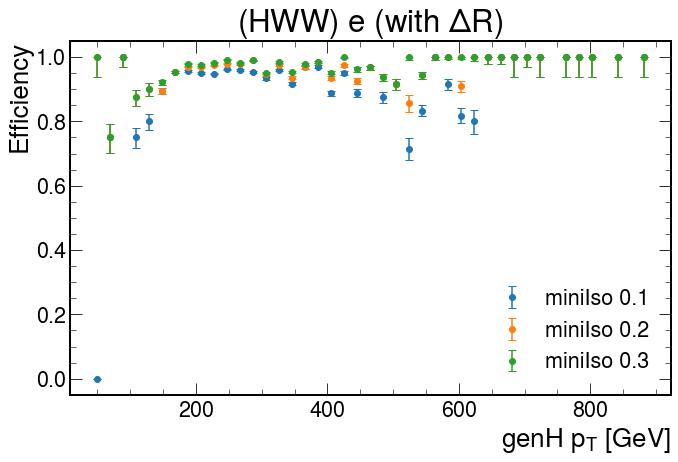

In [56]:
den = h[{"region":"hadel_dr"}]
num1 = h[{"region":"hadel_miniI_dr"}]
num2 = h[{"region":"hadel_miniII_dr"}]
num3 = h[{"region":"hadel_miniIII_dr"}]

genhpt = get_axis(den)
errI = error(num1, den)
errII = error(num2, den)
errIII = error(num3, den)

fig, ax = plt.subplots(
    figsize=(10,7),
    tight_layout=True,
)

ax.errorbar(
    genhpt,
    num1.values()/den.values(),
    fmt="o",
    yerr=errI,
    capsize=4,
    label="miniIso 0.1"
)
ax.errorbar(
    genhpt,
    num2.values()/den.values(),
    fmt="o",
    yerr=errII,
    capsize=4,
    label="miniIso 0.2"
)
ax.errorbar(
    genhpt,
    num3.values()/den.values(),
    fmt="o",
    yerr=errIII,
    capsize=4,
    label="miniIso 0.3"
)
ax.set(
    title="(HWW) $e$ (with $\Delta R$)",
    xlabel="genH $p_T$ [GeV]",
    ylabel="Efficiency"
)
ax.legend()
plt.gcf().savefig("hww_eminiIsoeff_dr.png")

/tmp/ipykernel_934/2640079242.py:2: RuntimeWarning: invalid value encountered in true_divide
  return abs(clopper_pearson_interval(num.values(), den.values()) - num.values()/den.values())
/tmp/ipykernel_934/2191562221.py:18: RuntimeWarning: invalid value encountered in true_divide
  num1.values()/den.values(),
/tmp/ipykernel_934/2191562221.py:26: RuntimeWarning: invalid value encountered in true_divide
  num2.values()/den.values(),
/tmp/ipykernel_934/2191562221.py:34: RuntimeWarning: invalid value encountered in true_divide
  num3.values()/den.values(),


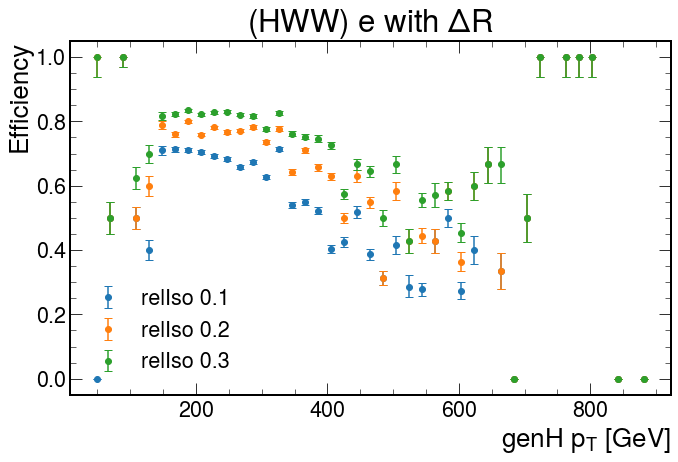

In [57]:
den = h[{"region":"hadel_dr"}]
num1 = h[{"region":"hadel_relI_dr"}]
num2 = h[{"region":"hadel_relII_dr"}]
num3 = h[{"region":"hadel_relIII_dr"}]

genhpt = get_axis(den)
errI = error(num1, den)
errII = error(num2, den)
errIII = error(num3, den)

fig, ax = plt.subplots(
    figsize=(10,7),
    tight_layout=True,
)

ax.errorbar(
    genhpt,
    num1.values()/den.values(),
    fmt="o",
    yerr=errI,
    capsize=4,
    label="relIso 0.1"
)
ax.errorbar(
    genhpt,
    num2.values()/den.values(),
    fmt="o",
    yerr=errII,
    capsize=4,
    label="relIso 0.2"
)
ax.errorbar(
    genhpt,
    num3.values()/den.values(),
    fmt="o",
    yerr=errIII,
    capsize=4,
    label="relIso 0.3"
)
ax.set(
    title="(HWW) $e$ with $\Delta R$",
    xlabel="genH $p_T$ [GeV]",
    ylabel="Efficiency"
)
ax.legend()
plt.gcf().savefig("hww_erelIsoeff_dr.png")

/tmp/ipykernel_934/2640079242.py:2: RuntimeWarning: invalid value encountered in true_divide
  return abs(clopper_pearson_interval(num.values(), den.values()) - num.values()/den.values())
/tmp/ipykernel_934/3353725887.py:20: RuntimeWarning: invalid value encountered in true_divide
  num1.values()/den.values(),
/tmp/ipykernel_934/3353725887.py:28: RuntimeWarning: invalid value encountered in true_divide
  num2.values()/den.values(),
/tmp/ipykernel_934/3353725887.py:36: RuntimeWarning: invalid value encountered in true_divide
  num3.values()/den.values(),


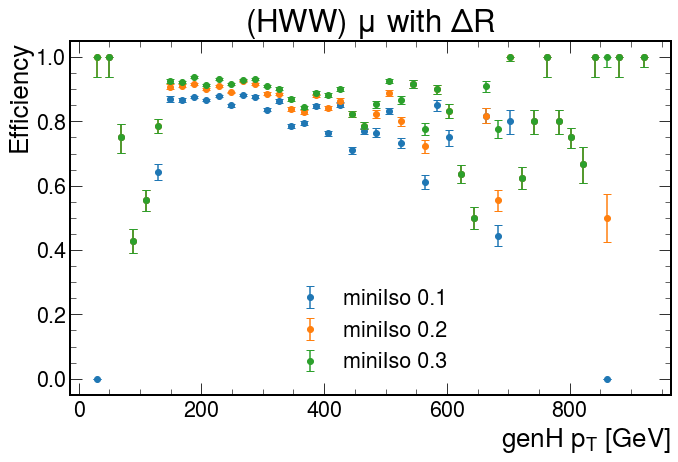

In [58]:
# electron isolation

den = h[{"region":"hadmu_dr"}]
num1 = h[{"region":"hadmu_miniI_dr"}]
num2 = h[{"region":"hadmu_miniII_dr"}]
num3 = h[{"region":"hadmu_miniIII_dr"}]

genhpt = get_axis(den)
errI = error(num1, den)
errII = error(num2, den)
errIII = error(num3, den)

fig, ax = plt.subplots(
    figsize=(10,7),
    tight_layout=True,
)

ax.errorbar(
    genhpt,
    num1.values()/den.values(),
    fmt="o",
    yerr=errI,
    capsize=4,
    label="miniIso 0.1"
)
ax.errorbar(
    genhpt,
    num2.values()/den.values(),
    fmt="o",
    yerr=errII,
    capsize=4,
    label="miniIso 0.2"
)
ax.errorbar(
    genhpt,
    num3.values()/den.values(),
    fmt="o",
    yerr=errIII,
    capsize=4,
    label="miniIso 0.3"
)
ax.set(
    title="(HWW) $\mu$ with $\Delta R$",
    xlabel="genH $p_T$ [GeV]",
    ylabel="Efficiency"
)
ax.legend()
plt.gcf().savefig("hww_muminiIsoeff_dr.png")

/tmp/ipykernel_934/2640079242.py:2: RuntimeWarning: invalid value encountered in true_divide
  return abs(clopper_pearson_interval(num.values(), den.values()) - num.values()/den.values())
/tmp/ipykernel_934/2139882409.py:18: RuntimeWarning: invalid value encountered in true_divide
  num1.values()/den.values(),
/tmp/ipykernel_934/2139882409.py:26: RuntimeWarning: invalid value encountered in true_divide
  num2.values()/den.values(),
/tmp/ipykernel_934/2139882409.py:34: RuntimeWarning: invalid value encountered in true_divide
  num3.values()/den.values(),


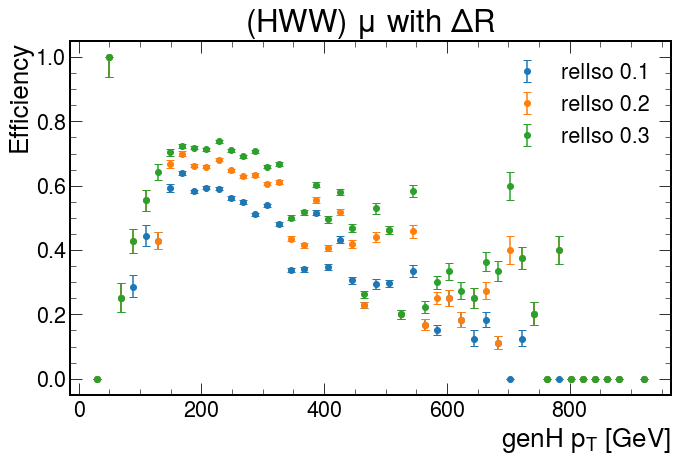

In [59]:
den = h[{"region":"hadmu_dr"}]
num1 = h[{"region":"hadmu_relI_dr"}]
num2 = h[{"region":"hadmu_relII_dr"}]
num3 = h[{"region":"hadmu_relIII_dr"}]

genhpt = get_axis(den)
errI = error(num1, den)
errII = error(num2, den)
errIII = error(num3, den)

fig, ax = plt.subplots(
    figsize=(10,7),
    tight_layout=True,
)

ax.errorbar(
    genhpt,
    num1.values()/den.values(),
    fmt="o",
    yerr=errI,
    capsize=4,
    label="relIso 0.1"
)
ax.errorbar(
    genhpt,
    num2.values()/den.values(),
    fmt="o",
    yerr=errII,
    capsize=4,
    label="relIso 0.2"
)
ax.errorbar(
    genhpt,
    num3.values()/den.values(),
    fmt="o",
    yerr=errIII,
    capsize=4,
    label="relIso 0.3"
)
ax.set(
    title="(HWW) $\mu$ with $\Delta R$",
    xlabel="genH $p_T$ [GeV]",
    ylabel="Efficiency"
)
ax.legend()
plt.gcf().savefig("hww_murelIsoeff_dr.png")